In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import constraints
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.interpolate import CubicSpline
import time
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format = 'svg'

## Importing device data

In [3]:
df=pd.read_excel('data_pot_dep_CNN-300_pot_dep_2V_1s_-2V_1s_-1V_200ms-pulse no.xlsx')

C:\Users\user\anaconda3\envs\snn_env_gpu\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [4]:
df.columns

Index(['Pulse No', 'PMU_SegArb_ExampleFull', 'VMeasCh1', 'IMeasCh1',
       'VMeasCh2', 'IMeasCh2', 'TimeOutput', 'StatusCh1', 'StatusCh2',
       'Conductance', 'Normalized conductance'],
      dtype='object')

In [5]:
df.head()

,Pulse No,PMU_SegArb_ExampleFull,VMeasCh1,IMeasCh1,VMeasCh2,IMeasCh2,TimeOutput,StatusCh1,StatusCh2,Conductance,Normalized conductance
0,1,0.0,-0.998114,-4.404342e-10,-0.498139,-5.208002e-10,1.360003,NaN,NaN,1.045491e-09,0.00000
1,2,NaN,-0.997289,-7.172821e-10,-0.495922,-8.248894e-10,2.760007,NaN,NaN,1.663344e-09,0.01691
2,3,NaN,-0.997434,-5.170343e-10,-0.496346,-1.248756e-09,4.160011,NaN,NaN,2.515900e-09,0.04025
3,4,NaN,-0.997570,-7.525620e-10,-0.496777,-1.769913e-09,5.560015,NaN,NaN,3.562791e-09,0.06891
4,5,NaN,-0.997622,-7.561775e-10,-0.496401,-2.234441e-09,6.960019,NaN,NaN,4.501284e-09,0.09460


## The potentiation-depression curve

### Deriving the curve

## Modeling STDP from Memristive Device Measurements

To incorporate biologically inspired plasticity into spiking neural networks, we derive an empirical spike-timing dependent plasticity (STDP) function from conductance measurements of memristive synaptic devices. The dataset comprises two continuous sequences of conductance values: one corresponding to long-term potentiation (LTP), denoted as $G_{\text{pot}}$, and the other to long-term depression (LTD), denoted as $G_{\text{dep}}$.

From each sequence, we compute the relative change in conductance using the normalized difference formula:

$$
\frac{\Delta G}{G_0} = \frac{G_{t+1} - G_t}{G_t + \varepsilon}
$$

where $\varepsilon$ is a small constant to ensure numerical stability. This yields two sequences of fractional conductance changes: one for potentiation and one for depression.

Each relative change is then mapped to a biologically meaningful spike timing difference $\Delta t$. Potentiation changes are associated with positive $\Delta t$ values, representing causal spike pairings ($\text{pre} \rightarrow \text{post}$), while depression changes are associated with negative $\Delta t$ values, reflecting anti-causal pairings ($\text{post} \rightarrow \text{pre}$). Specifically, we set:

$$
\Delta t_{\text{pot}} \in [1, 5] \quad \text{and} \quad \Delta t_{\text{dep}} \in [-5, -1]
$$

using uniformly sampled values to mimic experimental timing conditions.

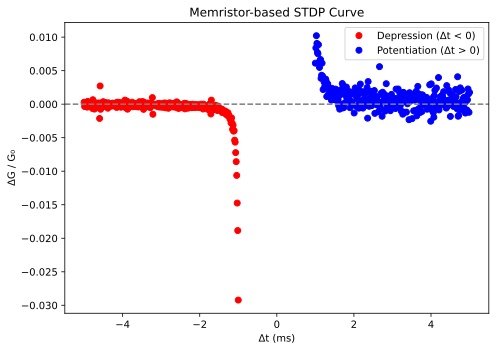

In [6]:
# === Load Data ===
G_pot = df['Conductance'].values[:300]
G_dep = df['Conductance'].values[300:]
pulse_numbers = np.arange(300)+1

# === Compute ΔG / G0 ===
dG_pot = np.diff(G_pot) / (G_pot[:-1] + 1e-7)
dG_dep = np.diff(G_dep) / (G_dep[:-1] + 1e-7)

# === Map to Δt ===
delta_t_pot = np.linspace(1, 5, len(dG_pot))     # LTP
delta_t_dep = np.linspace(-1, -5, len(dG_dep))   # LTD

# === Construct DataFrame ===
data = {
    'Delta_t': np.concatenate([delta_t_dep, delta_t_pot]),
    'Delta_G/G0': np.concatenate([dG_dep, dG_pot])
}
stdp_df = pd.DataFrame(data)

plt.figure(figsize=(7, 5))
plt.plot(delta_t_dep, dG_dep, 'ro', label='Depression (Δt < 0)')
plt.plot(delta_t_pot, dG_pot, 'bo', label='Potentiation (Δt > 0)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Δt (ms)")
plt.ylabel("ΔG / G₀")
plt.title("Memristor-based STDP Curve")
plt.legend()
plt.tight_layout()
plt.show()

### Fitting via spline (although non-smooth)

After sorting the resulting $(\Delta t, \Delta G / G_0)$ pairs, we fit cubic spline functions separately to the potentiation and depression regimes. Let $f_{\text{pot}}(\Delta t)$ and $f_{\text{dep}}(\Delta t)$ denote the fitted splines for potentiation and depression, respectively. These smooth, differentiable functions represent empirical approximations to the STDP learning window derived from physical measurements.

We define the final STDP rule as a piecewise function:

$$
\Delta w = 
\begin{cases}
f_{\text{pot}}(\Delta t), & \Delta t > 0 \\
f_{\text{dep}}(\Delta t), & \Delta t < 0 \\
0, & \Delta t = 0
\end{cases}
$$

where $\Delta t = t_{\text{post}} - t_{\text{pre}}$ denotes the temporal difference between post- and pre-synaptic spikes. These spline-based STDP kernels can be directly integrated into learning rules for spiking neural networks, enabling the use of physically measured synaptic behavior in simulation.


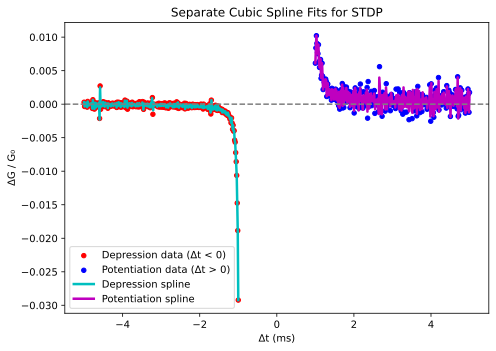

In [7]:
# Extract data from stdp_df
delta_t = stdp_df['Delta_t'].values
delta_g = stdp_df['Delta_G/G0'].values

# === Separate Δt into potentiation and depression ===
mask_pot = delta_t > 0
mask_dep = delta_t < 0

delta_t_pot = delta_t[mask_pot]
delta_g_pot = delta_g[mask_pot]
delta_t_dep = delta_t[mask_dep]
delta_g_dep = delta_g[mask_dep]

# === Sort before fitting splines ===
sort_pot = np.argsort(delta_t_pot)
sort_dep = np.argsort(delta_t_dep)

delta_t_pot_sorted = delta_t_pot[sort_pot]
delta_g_pot_sorted = delta_g_pot[sort_pot]

delta_t_dep_sorted = delta_t_dep[sort_dep]
delta_g_dep_sorted = delta_g_dep[sort_dep]

# === Fit Cubic Splines ===
spline_pot = CubicSpline(delta_t_pot_sorted, delta_g_pot_sorted)
spline_dep = CubicSpline(delta_t_dep_sorted, delta_g_dep_sorted)

# === Evaluate for plotting ===
t_pot_fine = np.linspace(delta_t_pot_sorted.min(), delta_t_pot_sorted.max(), 300)
t_dep_fine = np.linspace(delta_t_dep_sorted.min(), delta_t_dep_sorted.max(), 300)
g_pot_fine = spline_pot(t_pot_fine)
g_dep_fine = spline_dep(t_dep_fine)

# === Plot ===
plt.figure(figsize=(7, 5))
plt.scatter(delta_t_dep, delta_g_dep, color='red', label='Depression data (Δt < 0)', s=20)
plt.scatter(delta_t_pot, delta_g_pot, color='blue', label='Potentiation data (Δt > 0)', s=20)
plt.plot(t_dep_fine, g_dep_fine, 'c-', lw=2.5, label='Depression spline')
plt.plot(t_pot_fine, g_pot_fine, 'm-', lw=2.5, label='Potentiation spline')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Δt (ms)")
plt.ylabel("ΔG / G₀")
plt.title("Separate Cubic Spline Fits for STDP")
plt.legend()
plt.tight_layout()
plt.show()


## Importing the data used for classification task

### Importing data

In [8]:
# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

x_train_orig, x_test_orig = x_train, x_test
y_train_orig, y_test_orig = y_train, y_test

### Rate coding

To interface static image and label data with a spiking neural network (SNN), we transform continuous-valued inputs into temporally distributed binary spike trains using a rate coding scheme. This transformation allows neurons to emit spikes over discrete time steps in proportion to the intensity of their input signals.

Let $X \in [0, 1]^{B \times D}$ represent a batch of $B$ normalized input samples, each flattened to a feature dimension $D$. We aim to convert $X$ into spike trains $S \in \{0, 1\}^{B \times D \times T}$ over $T$ time steps. For each element $x_{bd} \in X$, a spike is generated at time step $t$ by sampling from a Bernoulli distribution:

$$
S_{bdt} \sim \text{Bernoulli}(x_{bd})
$$

This process is repeated independently across all time steps $t = 1, \dots, T$. As a result, the number of spikes emitted by each neuron over time is approximately proportional to its input intensity. Formally, the expected spike count over time for a feature $d$ of sample $b$ is:

$$
\mathbb{E}\left[\sum_{t=1}^T S_{bdt}\right] = T \cdot x_{bd}
$$

This rate encoding ensures that higher input values produce denser spike trains, while lower values yield sparse activity, thereby preserving input magnitude information in a temporally distributed binary representation.

The same principle applies to one-hot encoded class labels. Given a label matrix $Y \in \{0, 1\}^{B \times C}$, where $C$ is the number of classes, we generate label spike trains $L \in \{0, 1\}^{B \times C \times T}$ using:

$$
L_{bct} \sim \text{Bernoulli}(y_{bc})
$$

where $y_{bc} \in \{0, 1\}$ is the one-hot indicator for class $c$ of sample $b$. This converts categorical supervision into a temporally extended signal suitable for training spiking models using time-dependent losses.

Together, these rate-coded representations of both input and target activity enable training and inference in SNNs that process time-series spike data, while remaining compatible with conventional image and label formats like MNIST.


In [9]:
# ======================
# Rate Coding for Images (NumPy)
# ======================
def rate_coding(images, num_timesteps=10):
    """
    Convert images to spike trains with shape [batch, features, timesteps] using NumPy.
    Args:
        images: Normalized images (shape: [batch, height, width] or [batch, height*width])
        num_timesteps: Number of time steps (will be the last dimension).
    Returns:
        Spike trains (shape: [batch, features, timesteps])
    """
    if len(images.shape) > 2:
        images = images.reshape(images.shape[0], -1)  # Flatten to [batch, features]

    # Generate spikes: [batch, features, timesteps]
    spike_trains = np.random.rand(images.shape[0], images.shape[1], num_timesteps) < images[..., np.newaxis]
    return spike_trains.astype(np.float32)  # 1.0 = spike, 0.0 = no spike

# ======================
# Rate Coding for One-Hot Labels (TensorFlow)
# ======================
def rate_code_labels(one_hot_labels, num_timesteps=10):
    """
    Rate code one-hot encoded labels into spike trains using TensorFlow.
    Args:
        one_hot_labels: tf.Tensor or np.ndarray of shape [batch, num_classes]
        num_timesteps: number of time steps
    Returns:
        spike_trains: tf.Tensor of shape [batch, num_classes, timesteps]
    """
    if isinstance(one_hot_labels, np.ndarray):
        one_hot_labels = tf.convert_to_tensor(one_hot_labels, dtype=tf.float32)

    if len(one_hot_labels.shape) > 2:
        one_hot_labels = tf.reshape(one_hot_labels, [tf.shape(one_hot_labels)[0], -1])

    rand_vals = tf.random.uniform(shape=[tf.shape(one_hot_labels)[0], tf.shape(one_hot_labels)[1], num_timesteps])
    spike_trains = tf.cast(rand_vals < tf.expand_dims(one_hot_labels, -1), tf.float32)
    return spike_trains

# ======================
# Implement rate coding
# ======================

num_timesteps = 10  # Adjust as needed for your SNN model

# Image spike trains (NumPy-based)
x_train = rate_coding(x_train, num_timesteps)
x_test = rate_coding(x_test, num_timesteps)

# Label spike trains (TensorFlow-based)
y_train = rate_code_labels(y_train, num_timesteps)
y_test = rate_code_labels(y_test, num_timesteps)

# ======================
# Check Shapes
# ======================
print("x_train shape:", x_train.shape)  # Should be (60000, 784, num_timesteps)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)  # Should be (60000, 10, num_timesteps)
print("y_test shape:", y_test.shape)


x_train shape: (60000, 784, 10)
x_test shape: (10000, 784, 10)
y_train shape: (60000, 10, 10)
y_test shape: (10000, 10, 10)


## Designing a spike neural network and training the model

This spiking neural network (SNN) processes temporally encoded inputs using a single spiking layer with surrogate-gradient learning and a custom projection-based synaptic weight scheme.

The input to the network is a three-dimensional tensor denoted by $X \in \mathbb{R}^{B \times D_{\text{in}} \times T}$, where $B$ is the batch size, $D_{\text{in}}$ is the dimensionality of the input layer (i.e., the number of input neurons), and $T$ is the number of discrete time steps in the simulation. For each time step $t$, the input slice $X_t \in \mathbb{R}^{B \times D_{\text{in}}}$ is fed into the spiking layer.

Unlike traditional dense layers, the synaptic weights in this model are not represented by a single matrix. Instead, they are constructed through the product of two learnable matrices: a pre-synaptic projection matrix $W_{\text{pre}} \in \mathbb{R}^{T \times D_{\text{in}}}$ and a post-synaptic projection matrix $W_{\text{post}} \in \mathbb{R}^{D_{\text{out}} \times T}$. The full weight matrix $W \in \mathbb{R}^{D_{\text{out}} \times D_{\text{in}}}$ is computed as:

$$
W = W_{\text{post}} \cdot W_{\text{pre}}
$$

This factorization encodes temporal structure into the weights while maintaining a reduced number of parameters.

The dynamics of each output neuron are governed by leaky integration of post-synaptic currents. At each time step $t$, the membrane potential $V^{(t)} \in \mathbb{R}^{B \times D_{\text{out}}}$ is updated according to the equation:

$$
V^{(t)} = \alpha V^{(t-1)} + X_t \cdot W^\top
$$

Here, $\alpha$ denotes the decay constant that controls the leak rate of the membrane potential. This leaky accumulation allows neurons to integrate inputs over time.

Spikes are generated based on a thresholding operation. If the membrane potential exceeds a fixed threshold $\theta$, the neuron emits a spike. The spiking output $S^{(t)} \in \mathbb{R}^{B \times D_{\text{out}}}$ is determined by a spike function $\sigma(\cdot)$ applied to the thresholded membrane potential:

$$
S^{(t)} = \sigma(V^{(t)} - \theta)
$$

Since the hard threshold function is non-differentiable, a surrogate gradient is employed during backpropagation, If one chooses to use backpropagation to train the model. In the forward pass, the spike function acts as a binary indicator:

$$
\sigma(x) = \mathbb{1}_{x > 0}
$$

During training, its gradient is approximated by a cubic surrogate defined as:

$$
\frac{d\sigma}{dx} \approx \left[\max(0, 1 - |x|)\right]^3
$$

Following the emission of a spike, the corresponding membrane potential is reset according to:

$$
V^{(t)} \leftarrow V^{(t)} \cdot (1 - S^{(t)})
$$

This ensures that a neuron cannot spike repeatedly due to a high potential carried over from previous time steps.

The final output of the network is a spike tensor $S \in \mathbb{R}^{B \times D_{\text{out}} \times T}$, which captures the binary spiking activity of each output neuron over the course of the simulation. This output can be further processed or decoded depending on the task, such as classification via spike count or timing-based readouts.


In [15]:
# --- Surrogate Spike Function ---
@tf.custom_gradient
def spike_function(x):
    def grad(dy):
        sg = tf.maximum(0., 1. - tf.abs(x))**3  # Cubic surrogate gradient
        return dy * sg
    return tf.cast(x > 0.5, tf.float32), grad

# --- Spiking Dense Layer with Soft Lateral Inhibition ---
class SpikingDense(tf.keras.layers.Layer):
    def __init__(self, units, threshold=0.5, num_timesteps=5, decay=0.95, inhibition_strength=0.2, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.threshold = threshold
        self.num_timesteps = num_timesteps
        self.decay = decay
        self.inhibition_strength = inhibition_strength  # Soft inhibition scalar

    def build(self, input_shape):
        self.input_dim = input_shape[-2]

        # Learnable pre-synaptic projection (time × input_dim)
        self.w_pre = self.add_weight(
            shape=(self.num_timesteps, self.input_dim),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            trainable=True,
            name="w_pre"
        )

        # Learnable post-synaptic projection (units × time)
        self.w_post = self.add_weight(
            shape=(self.units, self.num_timesteps),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1),
            trainable=True,
            name="w_post"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        v_mem = tf.zeros((batch_size, self.units))
        outputs = tf.TensorArray(tf.float32, size=self.num_timesteps)
    
        def body(t, v_mem, outputs):
            x_t = inputs[:, :, t]  # (batch, input_dim)
    
            # --- Break down weight flow ---
            # (batch, input_dim) x (input_dim,) = (batch,)
            I_pre_t = tf.einsum('bi,ti->bt', x_t, self.w_pre)     # (batch, time)
            I_t = tf.einsum('bt,jt->bj', I_pre_t, self.w_post)    # (batch, units)
    
            # Leaky integration
            v_mem = v_mem * self.decay + I_t
    
            # --- Soft Lateral Inhibition ---
            inhibition = self.inhibition_strength * tf.reduce_mean(v_mem, axis=1, keepdims=True)
            v_mem = tf.nn.relu(v_mem - inhibition)
    
            # Spike and reset
            spike_out = spike_function(v_mem - self.threshold)
            v_mem = v_mem * (1 - spike_out)
    
            outputs = outputs.write(t, spike_out)
            return t + 1, v_mem, outputs
    
        _, _, outputs = tf.while_loop(
            cond=lambda t, *_: t < self.num_timesteps,
            body=body,
            loop_vars=(0, v_mem, outputs)
        )
    
        return tf.transpose(outputs.stack(), [1, 2, 0])  # (batch, units, time)



# --- Build SNN Model with User-Defined Time Steps ---

def build_snn(num_timesteps=5):
    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")
    
    # Output layer
    x = SpikingDense(
        784, 
        threshold=0.5,  
        num_timesteps=num_timesteps, 
        name="output_layer"
    )(inputs)
    
    return tf.keras.Model(inputs=inputs, outputs=x)


model = build_snn(num_timesteps=num_timesteps)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 784, 10)]         0         
                                                                 
 output_layer (SpikingDense)  (None, 784, 10)          15680     
                                                                 
Total params: 15,680
Trainable params: 15,680
Non-trainable params: 0
_________________________________________________________________


# Windowed Spline-Modulated Van Rossum Loss

To impose **biologically-inspired temporal credit assignment** while limiting computational overhead, we introduce the **Windowed Spline-Modulated Van Rossum Loss**. This loss function is a variant of the spline-based Van Rossum loss designed for **spiking neural networks (SNNs)**. Unlike standard losses that treat spikes as independent events, this loss explicitly models **temporal dependencies** in spike trains while restricting the influence to a finite causal window.  

---

## Spike Trains

Let  

$$
Y_{\text{true}}, Y_{\text{pred}} \in \mathbb{R}^{B \times D \times T}
$$

denote the **ground-truth** and **predicted spike trains**, where:  

- $B$ is the batch size,  
- $D$ is the number of neurons, and  
- $T$ is the number of discrete time steps.  

---

## Windowed STDP Kernel

We define a **windowed STDP kernel** $\kappa_w(\Delta t)$ over a symmetric temporal window  

$$
\Delta t \in [-\Delta_{\max}, \Delta_{\max}]
$$

as follows:

$$
\kappa_w(\Delta t) =
\begin{cases}
f_{+}(\Delta t), & \Delta t > 0 \quad \text{(pre-before-post potentiation)} \\
f_{-}(\Delta t), & \Delta t < 0 \quad \text{(pre-after-post depression)} \\
0, & \Delta t = 0
\end{cases}, \quad |\Delta t| \le \Delta_{\max}
$$

where:

- $f_{+}(\Delta t)$ models **potentiation** (synaptic strengthening),  
- $f_{-}(\Delta t)$ models **depression** (synaptic weakening).  

The kernel is **normalized** to maintain consistent magnitude:

$$
\sum_{\Delta t=-\Delta_{\max}}^{\Delta_{\max}} \kappa_w(\Delta t) = 1
$$

---

## Temporal Convolution

Each spike train is **filtered along the temporal axis** by convolving with the kernel $\kappa_w$:

$$
\tilde{Y}_{\text{true}}[b,i,t] = \sum_{\Delta t=-\Delta_{\max}}^{\Delta_{\max}} \kappa_w(\Delta t) \, Y_{\text{true}}[b,i,t-\Delta t]
$$

$$
\tilde{Y}_{\text{pred}}[b,i,t] = \sum_{\Delta t=-\Delta_{\max}}^{\Delta_{\max}} \kappa_w(\Delta t) \, Y_{\text{pred}}[b,i,t-\Delta t]
$$

- The convolution is applied **independently for each neuron $i$ and batch $b$**.  
- The **temporal window $\Delta_{\max}$** ensures that only nearby spikes influence each other, emphasizing **local spike timing dependencies**.  
- Padding can be applied to preserve the original temporal length $T$.

---

## Loss Function

The final **mean squared error** between the filtered spike trains defines the loss:

$$
\mathcal{L}_{\text{windowed\_spline\_van\_rossum}} =
\frac{1}{B D T} \sum_{b=1}^{B} \sum_{i=1}^{D} \sum_{t=1}^{T} 
\big( \tilde{Y}_{\text{true}}[b,i,t] - \tilde{Y}_{\text{pred}}[b,i,t] \big)^2
$$

- This loss measures differences in **smoothed spike timing patterns** rather than just spike counts.  
- By incorporating $\kappa_w$, the loss effectively implements a **temporal credit assignment** mechanism inspired by **STDP**.

---

## Advantages

1. **Biologically plausible**: Mimics synaptic potentiation and depression based on spike timing.  
2. **Local temporal interactions**: Only spikes within $[- \Delta_{\max}, + \Delta_{\max}]$ contribute, reducing computation.  
3. **Differentiable**: Spline-based kernels allow gradient-based optimization for SNN training.  
4. **Efficient**: Truncated kernel reduces the complexity from $O(T^2)$ to $O(T \cdot \Delta_{\max})$.  
5. **Neuromorphic relevance**: Suitable for **on-chip implementations** where long-range interactions are costly.

---

✅ **Summary**:  

> The Windowed Spline-Modulated Van Rossum Loss compares predicted and true spike trains by first **filtering them with a local STDP-shaped kernel**, then computing the **MSE of the filtered traces**. This enforces **precise, local spike timing alignment** in a biologically-inspired, computationally efficient manner.


In [16]:
def windowed_spline_van_rossum_kernel(max_dt, spline_pot, spline_dep):
    """
    Create a 1D van Rossum-style kernel with spline-based STDP weights,
    limited to a window of [-max_dt, ..., +max_dt].
    """
    delta_range = np.arange(-max_dt, max_dt + 1)  # Symmetric window
    kernel_vals = np.zeros_like(delta_range, dtype=np.float32)

    for i, dt in enumerate(delta_range):
        if dt > 0:
            kernel_vals[i] = spline_pot(dt)
        elif dt < 0:
            kernel_vals[i] = spline_dep(dt)
        else:
            kernel_vals[i] = 0.0  # Typically no update at Δt = 0

    kernel_vals -= np.min(kernel_vals)  # Shift to non-negative
    kernel_vals /= np.sum(kernel_vals) + 1e-8  # Normalize to sum=1
    return tf.convert_to_tensor(kernel_vals, dtype=tf.float32)


def spline_modulated_windowed_symmetric_van_rossum_loss(y_true, y_pred, spline_pot, spline_dep, max_dt=5):
    """
    Windowed version of spline-based van Rossum loss that only considers spike
    interactions within a ±max_dt time window.
    """
    T_int = y_pred.shape[-1]
    if T_int is None:
        T_int = tf.shape(y_pred)[-1]

    # Create truncated kernel
    kernel_1d = windowed_spline_van_rossum_kernel(max_dt, spline_pot, spline_dep)
    kernel_len = 2 * max_dt + 1

    # Reshape kernel for depthwise conv
    kernel = tf.reshape(kernel_1d, (kernel_len, 1, 1))  # (filter_width, in_channels, channel_multiplier)

    # Prepare input shapes: (B, C, T) → (B*C, T, 1)
    batch_size = tf.shape(y_true)[0]
    num_units = tf.shape(y_true)[1]

    y_true_flat = tf.reshape(tf.transpose(y_true, [0, 2, 1]), [-1, T_int, 1])
    y_pred_flat = tf.reshape(tf.transpose(y_pred, [0, 2, 1]), [-1, T_int, 1])

    # Apply 1D convolution with 'SAME' padding
    y_true_filt = tf.nn.conv1d(
        y_true_flat,
        filters=kernel,
        stride=1,
        padding='SAME',
        data_format='NWC'
    )

    y_pred_filt = tf.nn.conv1d(
        y_pred_flat,
        filters=kernel,
        stride=1,
        padding='SAME',
        data_format='NWC'
    )

    # Reshape back to original dimensions
    y_true_filt = tf.transpose(
        tf.reshape(y_true_filt, [batch_size, T_int, num_units]),
        [0, 2, 1]
    )
    y_pred_filt = tf.transpose(
        tf.reshape(y_pred_filt, [batch_size, T_int, num_units]),
        [0, 2, 1]
    )

    # Compute MSE between filtered signals
    return tf.reduce_mean(tf.square(y_true_filt - y_pred_filt))

In [17]:
def train_off_chip_device_specific(model, x_train, y_train, loss_fn,
                   epochs=10, batch_size=32, learning_rate=0.01,
                   test_image=None, verbose=True):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Ensure y_train has proper shape (B, C, T)
    if len(y_train.shape) == 2:
        y_train = tf.expand_dims(y_train, -1)
        y_train = tf.tile(y_train, [1, 1, model.output_shape[-1]])
    
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    output_layer = model.get_layer("output_layer")
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_loss = tf.keras.metrics.Mean()
        
        for x_batch, y_batch in tqdm(dataset, desc=f"Epoch {epoch+1}"):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch)
                loss = loss_fn(x_batch, y_pred)
            
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Track metrics
            epoch_loss.update_state(loss)
            avg_output_spikes = tf.reduce_mean(y_pred)

        print(f"  Output spike avg: {avg_output_spikes:.4f}")
        print(f"Epoch {epoch+1} loss: {epoch_loss.result().numpy():.4f}")

        
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss.result().numpy():.4f}")
            if test_image is not None:
                test_spikes = model(test_image)
                plot_spiking_activation_map(test_spikes)

In [18]:
def plot_spiking_activation_map(spiking_output):
    """
    Plot spiking layer activation as a dot heatmap from a single model output.
    
    Parameters:
        spiking_output (tf.Tensor or np.ndarray): Shape (1, num_neurons, time_steps)
        save_path (str): File path to save the generated plot
    """
    # Convert to NumPy if it's a TensorFlow tensor
    if isinstance(spiking_output, tf.Tensor):
        spiking_output = spiking_output.numpy()
    
    # Remove batch dimension and sum over time axis
    spike_activations = np.sum(spiking_output.squeeze(), axis=-1)  # Shape: (num_neurons,)

    # Infer a 2D grid size for plotting
    num_neurons = spike_activations.shape[0]
    grid_size = int(np.sqrt(num_neurons))
    if grid_size * grid_size != num_neurons:
        raise ValueError(f"Cannot reshape {num_neurons} neurons into a square grid. Consider custom shape.")

    # Reshape for grid visualization
    activation_grid = spike_activations.reshape(grid_size, grid_size)

    # Generate grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    x_coords, y_coords = x_coords.flatten(), y_coords.flatten()
    activation_values = activation_grid.flatten()

    # Plot the activation as a dot heatmap
    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(x_coords, y_coords, c=activation_values, cmap='hot', s=70, alpha=0.75)
    #plt.colorbar(scatter, label="Spike Intensity")
    plt.gca().invert_yaxis()
    #plt.title("Spiking Layer Activations (Dot Heatmap)")
    plt.xticks([])
    plt.yticks([])
    #plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

## Device-specific Off Chip Training

### Using Spline-Modulated Windowed Symmetric Van Rossum Loss


Epoch 1/3


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 1875/1875 [04:41<00:00,  6.67it/s]

  Output spike avg: 0.1545
Epoch 1 loss: 0.0108
Epoch 1/3, Loss: 0.0108


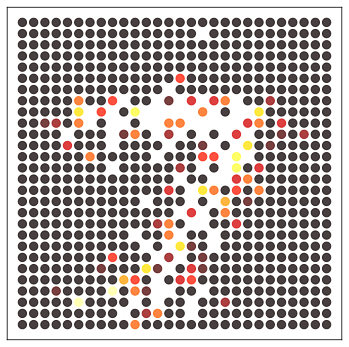


Epoch 2/3


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 1875/1875 [04:45<00:00,  6.57it/s]

  Output spike avg: 0.1596
Epoch 2 loss: 0.0078
Epoch 2/3, Loss: 0.0078


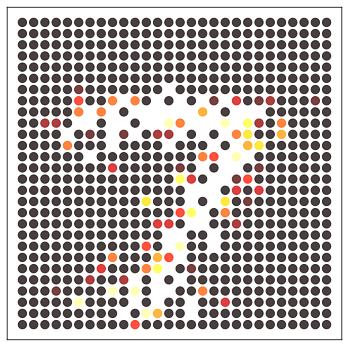


Epoch 3/3


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 1875/1875 [04:43<00:00,  6.60it/s]


  Output spike avg: 0.1452
Epoch 3 loss: 0.0075
Epoch 3/3, Loss: 0.0075


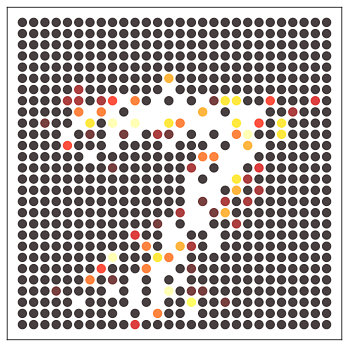

In [19]:
model_spline_modulated_windowed_symmetric_van_rossum_loss = build_snn(num_timesteps=num_timesteps)

loss_fn = lambda y_true, y_pred: spline_modulated_windowed_symmetric_van_rossum_loss(
    y_true, y_pred, spline_pot, spline_dep
)

train_off_chip_device_specific(model_spline_modulated_windowed_symmetric_van_rossum_loss, x_train, y_train, loss_fn,
                epochs=3, batch_size=32, learning_rate=0.001,
                test_image=x_test[0:1])

## Validation

### Collecting all learnt features on the test data from the On-chip, Off-chip and On-chip device specific models

In [15]:
models_dict={ 
        'spline_modulated_windowed_symmetric_van_rossum_loss': model_spline_modulated_windowed_symmetric_van_rossum_loss
            }

In [16]:
# --- Build classifier on top of a frozen model ---
def build_frozen_classifier(frozen_model, num_timesteps=10):
    frozen_model.trainable = False  # freeze base SNN

    inputs = tf.keras.Input(shape=(784, num_timesteps), name="input_layer")

    # Pass through frozen SNN
    x = frozen_model(inputs)

    # Flatten across neurons and time
    x = tf.keras.layers.Flatten()(x)

    # Trainable classification head
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# --- Train and evaluate all models ---
def train_and_evaluate_all(models_dict, x_train, y_train_orig, x_test, y_test_orig,
                           num_timesteps=10, epochs=10, batch_size=64):
    results = {}

    for name, base_model in models_dict.items():
        print(f"\n⚙️  Processing model: {name}")

        # Build and compile classifier
        classifier = build_frozen_classifier(base_model, num_timesteps)
        classifier.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

        # Train classifier head
        classifier.fit(x_train, y_train_orig,
                       validation_split=0.1,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1)

        # Predict and evaluate
        y_pred_probs = classifier.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test_orig, axis=1)

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        results[name] = {'accuracy': acc, 'confusion_matrix': cm}

        # --- Plot confusion matrix ---
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{name}\nAccuracy: {acc:.4f}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    return results



⚙️  Processing model: spline_modulated_windowed_symmetric_van_rossum_loss
Epoch 1/10
3375/3375 [==============================] - 38s 11ms/step - loss: 0.3325 - accuracy: 0.8954 - val_loss: 0.2189 - val_accuracy: 0.9345
Epoch 2/10
3375/3375 [==============================] - 39s 12ms/step - loss: 0.2259 - accuracy: 0.9266 - val_loss: 0.2018 - val_accuracy: 0.9395
Epoch 3/10
3375/3375 [==============================] - 42s 13ms/step - loss: 0.1895 - accuracy: 0.9381 - val_loss: 0.2216 - val_accuracy: 0.9383
Epoch 4/10
3375/3375 [==============================] - 36s 11ms/step - loss: 0.1656 - accuracy: 0.9453 - val_loss: 0.1897 - val_accuracy: 0.9440
Epoch 5/10
3375/3375 [==============================] - 37s 11ms/step - loss: 0.1396 - accuracy: 0.9530 - val_loss: 0.1975 - val_accuracy: 0.9393
Epoch 6/10
3375/3375 [==============================] - 38s 11ms/step - loss: 0.1215 - accuracy: 0.9579 - val_loss: 0.2116 - val_accuracy: 0.9413
Epoch 7/10
3375/3375 [===========================

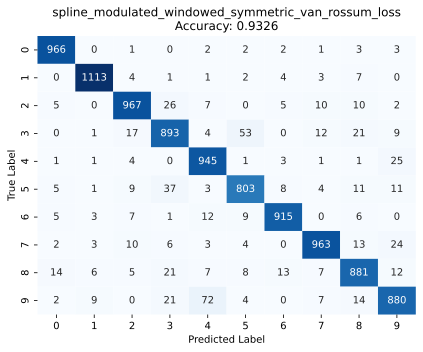

In [17]:
results = train_and_evaluate_all(
    models_dict,
    x_train, y_train_orig,
    x_test, y_test_orig,
    num_timesteps=10,
    epochs=10,
    batch_size=16
)